# Lab - Recommender System


In [113]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

1.1 - Movielens full - EDA
Nu ska du ladda ned datasetet ml-latest.zip under sektionen "recommended for education and
development". Ladda in dataseten "movies.csv" och "ratings.csv" besvara på följande frågor:

a) Gör en EDA för att förstå datasetet. Inkludera olika slags plots. Begränsa dig inte till frågorna nedan,
utan försök undersöka fler aspekter av datan.

In [3]:
movies = pd.read_csv("../../Data/ml-latest/movies.csv")
ratings = pd.read_csv("../../Data/ml-latest/ratings.csv")

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [6]:
ratings["movieId"].nunique()

53889

In [198]:
all_genres = movies["genres"].unique() # Picks out all unique combinations of genres to ease the loop
genres = []
for genre in all_genres:
    temp = genre.split("|") # Splits the string and stores it as a list in a temporary variable
    genres.extend(temp) 

unique_genres = list(set(genres)) # Picks out the unique genres
unique_genres.remove("(no genres listed)")
print(unique_genres)

['Thriller', 'Mystery', 'Sci-Fi', 'Romance', 'IMAX', 'Documentary', 'Horror', 'Action', 'Crime', 'Film-Noir', 'Drama', 'Musical', 'Adventure', 'Animation', 'Fantasy', 'Comedy', 'Western', 'Children', 'War']


In [199]:
number_of_occurences = []
for genre in unique_genres:
    number_of_occurences.append(movies["genres"].str.count(genre).sum())

print(number_of_occurences)

[8216, 2773, 3444, 7412, 197, 5118, 5555, 7130, 5105, 364, 24144, 1113, 4067, 2663, 2637, 15956, 1378, 2749, 1820]


In [207]:
genres_occurences = pd.DataFrame({"Genre":unique_genres, "Occurences":number_of_occurences})
genres_occurences

,Genre,Occurences
0,Thriller,8216
1,Mystery,2773
2,Sci-Fi,3444
3,Romance,7412
4,IMAX,197
5,Documentary,5118
6,Horror,5555
7,Action,7130
8,Crime,5105
9,Film-Noir,364


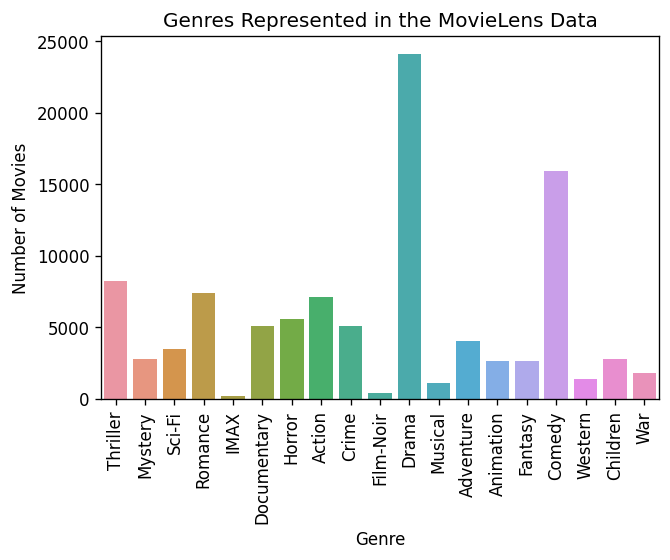

In [209]:
fig = plt.figure(dpi=120)
ax = sns.barplot(x=genres_occurences["Genre"], y=genres_occurences["Occurences"])

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
_ = ax.set(title="Genres Represented in the MovieLens Data", ylabel="Number of Movies")

b) Vilka är de 10 filmerna med flest ratings?

In [7]:
most_ratings = ratings["rating"].groupby(ratings["movieId"]).count()
most_ratings = pd.DataFrame(most_ratings.sort_values(ascending=False).head(10)).reset_index()
most_ratings = most_ratings.rename({"rating":"Number of Ratings"}, axis=1)
most_ratings

,movieId,Number of Ratings
0,318,97999
1,356,97040
2,296,92406
3,593,87899
4,2571,84545
5,260,81815
6,480,76451
7,527,71516
8,110,68803
9,1,68469


In [8]:
movies_most_ratings = pd.merge(most_ratings, 
                            movies.loc[movies["movieId"].isin(most_ratings["movieId"])], 
                            on="movieId"
                            )
movies_most_ratings

,movieId,Number of Ratings,title,genres
0,318,97999,"Shawshank Redemption, The (1994)",Crime|Drama
1,356,97040,Forrest Gump (1994),Comedy|Drama|Romance|War
2,296,92406,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,593,87899,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
4,2571,84545,"Matrix, The (1999)",Action|Sci-Fi|Thriller
5,260,81815,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
6,480,76451,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
7,527,71516,Schindler's List (1993),Drama|War
8,110,68803,Braveheart (1995),Action|Drama|War
9,1,68469,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


c) Beräkna den genomsnittliga ratingen för dessa 10 filmerna med flest ratings.

In [9]:
rating_of_most_rated = ratings.loc[ratings["movieId"].isin(most_ratings["movieId"])]
rating_of_most_rated = rating_of_most_rated["rating"].groupby(rating_of_most_rated["movieId"]).mean()


In [160]:
movies_most_rated = pd.merge(movies_most_ratings, 
                            pd.DataFrame({"Mean Rating":rating_of_most_rated}).reset_index(), 
                            on="movieId")
movies_most_rated

,movieId,Number of Ratings,title,genres,Mean Rating
0,318,97999,"Shawshank Redemption, The (1994)",Crime|Drama,4.424188
1,356,97040,Forrest Gump (1994),Comedy|Drama|Romance|War,4.056585
2,296,92406,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.173971
3,593,87899,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.151412
4,2571,84545,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.149695
5,260,81815,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.120455
6,480,76451,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,3.665034
7,527,71516,Schindler's List (1993),Drama|War,4.257502
8,110,68803,Braveheart (1995),Action|Drama|War,4.008481
9,1,68469,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.886649


d) Gör en plot över årtal och antalet filmer representerade i datasettet.

In [97]:
year_of_movies = movies["title"].str.extract(r"(\(\d{4}\))") # Extract all years in the format (dddd)
year_of_movies = year_of_movies[0].str.extract(r"(\d{4})").rename({0:"Year"}, axis=1) # Removes the parantheses
year_of_movies = pd.DataFrame(year_of_movies["Year"].dropna().astype(int))
year_of_movies

,Year
0,1995
1,1995
2,1995
3,1995
4,1995
...,...
58093,1946
58094,2011
58095,2016
58096,2017


In [220]:
movies_per_year = pd.DataFrame(year_of_movies["Year"].value_counts()).rename({"Year":"Count"}, axis=1)
movies_per_year = movies_per_year.drop(2018) # Remove 2018, since the data is insufficient for this year (dataset was updated 9/2018)
movies_per_year

,Count
2015,2312
2014,2297
2016,2219
2013,2187
2012,2019
...,...
1887,1
1878,1
1874,1
1893,1


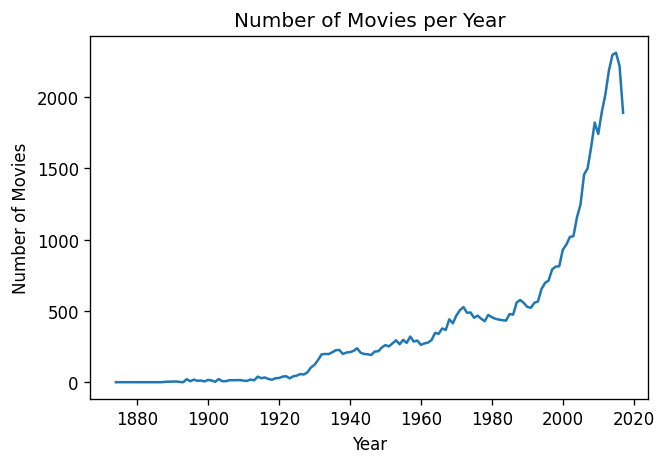

In [223]:
fig = plt.figure(dpi=120)
ax = sns.lineplot(x=movies_per_year.index, y=movies_per_year["Count"])
_ = ax.set(title="Number of Movies per Year", xlabel="Year", ylabel="Number of Movies")

In [127]:
movies.loc[movies["title"].str.contains("1874", case=False)]

,movieId,title,genres
37886,148054,Passage de Venus (1874),Documentary


e) Gör en plot över antalet ratings mot movieId.

In [135]:
most_ratings2 = ratings["rating"].groupby(ratings["movieId"]).count()
most_ratings2 = pd.DataFrame(most_ratings2).reset_index()


In [134]:
most_ratings2

,movieId,rating
0,1,68469
1,2,27143
2,3,15585
3,4,2989
4,5,15474
...,...,...
53884,193876,1
53885,193878,1
53886,193880,1
53887,193882,1


<AxesSubplot:xlabel='movieId', ylabel='rating'>

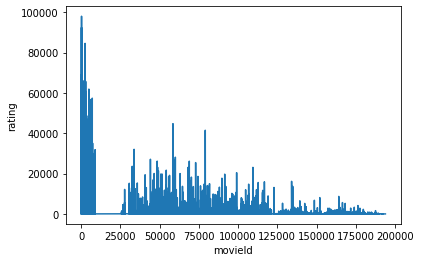

In [163]:
sns.lineplot(x=most_ratings2["movieId"], y=most_ratings2["rating"]) #????

f) Beräkna genomsnittliga ratings för de top 10 filmerna med flest ratings. Gör ett stapeldiagram över
dessa.

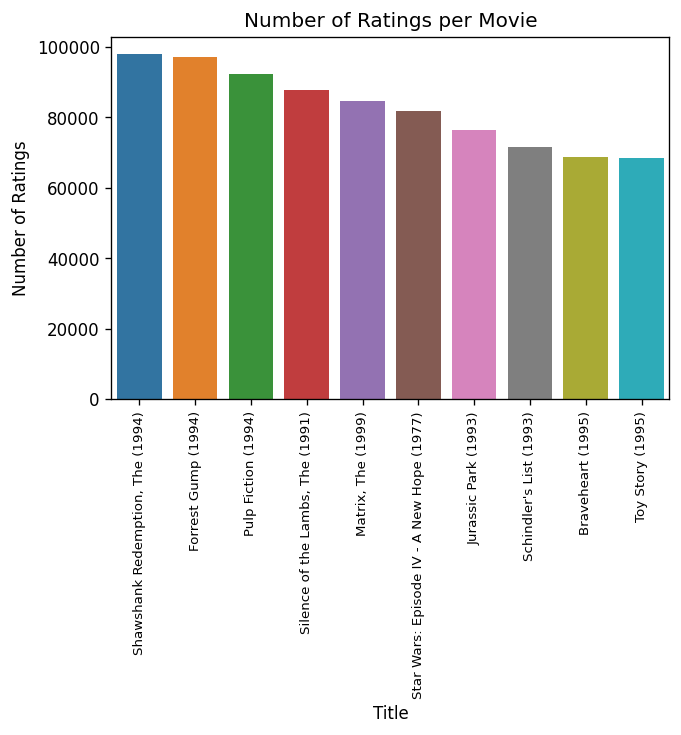

In [228]:
fig = plt.figure(dpi=120)
ax = sns.barplot(x=movies_most_rated["title"], y=movies_most_rated["Number of Ratings"])
ax.set(title="Number of Ratings per Movie", xlabel="Title")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, size=8)